<a href="https://www.kaggle.com/code/utkarshtomar736/mixup-labelsmoothing?scriptVersionId=195434089" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [18]:
from fastai.vision.all import *

path = untar_data(URLs.IMAGENETTE)

In [19]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items = get_image_files,
                   get_y = parent_label,
                   item_tfms = Resize(460),
                   batch_tfms = aug_transforms(size=224, min_scale=0.75))
                   
dls = dblock.dataloaders(path, bs=64)

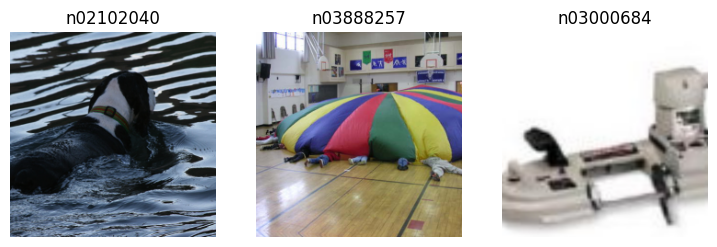

In [20]:
dls.show_batch(nrows=1, ncols=3)

In [21]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.729823,2.948787,0.314040,02:22
1,1.229816,1.719847,0.540702,02:22
2,0.950803,0.843406,0.729276,02:22
3,0.739009,0.739524,0.772218,02:22
4,0.605045,0.577978,0.824869,02:23


## Normalization

In [22]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([0.4414, 0.4427, 0.4105], device='cuda:0'),
 TensorImage([0.2912, 0.2761, 0.2873], device='cuda:0'))

In [23]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                      get_items = get_image_files,
                      get_y = parent_label,
                      item_tfms = Resize(460),
                      batch_tfms = [*aug_transforms(size=size, min_scale=0.75),
                                   Normalize.from_stats(*imagenet_stats)])
    
    return dblock.dataloaders(path, bs=bs)

In [24]:
dls = get_dls(64, 224)

In [25]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([-0.1149, -0.0935,  0.0548], device='cuda:0'),
 TensorImage([1.2606, 1.2607, 1.3096], device='cuda:0'))

In [26]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.606278,3.096985,0.377894,02:23
1,1.290410,1.794544,0.540702,02:22
2,0.976495,1.252998,0.643017,02:22
3,0.755589,0.712208,0.775952,02:22
4,0.614509,0.579609,0.819268,02:22


## Progressive Resizing

In [27]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.792543,2.118040,0.462659,01:11
1,1.255112,1.358738,0.576550,01:12
2,0.955087,0.848764,0.735997,01:11
3,0.730756,0.654697,0.797237,01:10


In [28]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.824327,1.426766,0.614264,02:23


epoch,train_loss,valid_loss,accuracy,time
0,0.651289,0.765011,0.748693,02:23
1,0.646958,0.650978,0.805825,02:23
2,0.572999,0.558819,0.826363,02:23
3,0.494928,0.493104,0.848021,02:22
4,0.454392,0.467471,0.852502,02:22


## Test Time Augmentation

In [29]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.8592233061790466

## MixUp

In [31]:
mixup = MixUp(0.5)

In [33]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.177351,2.520661,0.375280,01:10
1,1.705947,1.217066,0.622853,01:10
2,1.482886,1.090870,0.665049,01:10
3,1.300647,0.755604,0.777072,01:10
4,1.172103,0.692967,0.803211,01:10


## Label Smoothing

In [34]:
model = xresnet50()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.767297,3.724366,0.326736,01:10
1,2.278459,2.968047,0.377521,01:10
2,1.961866,2.018370,0.659821,01:11
3,1.756399,1.723643,0.765870,01:10
4,1.626837,1.598734,0.810680,01:09
